# Nutrition Dashboard
8/12/2022

## Initial Thoughts and Assumptions

Specify a series of "nutrient axes" -- category groupings from chart. (e.g. Energy, Vitamins, Minerals, etc.)

Assume that, for each grouping, these axes from an orthogonal basis ${a_i}$ in a multi-dimensional vector space $V$. For now, assume that these nutrient axes are orthogonal. (We can revisit this assumption later)

Assume each nutrient axis $a_i$ has a minimum value per day. (and a maximum value, $X_i$, if applicable)

Assume that each nutrient axis is normalized / scaled relative to the minimum needed per day. That way, each axis will have a value of "1" for the minimum amount needed per day. 

Assume you have a list of different potential foods. Each food type, $\vec{f_j}$, is a vector in this multidimensional space $V$. Representing $\vec{f_j}$ as a vector shows how far along each nutrition axis a single serving of the food $j$ will get you. In general, a single food will likely have nutrition value along multiple axes. Food vectors can be scaled by increasing the number of servings.

The goal is to find (at least one) minimum spanning set of food vectors for falling within the min/max bounds of a given nutrient space.

## Objective and Constraints

Suppose we have a buffet $B$ of $M$ different possible food vectors ($\vec{f_1}$, $\vec{f_2}$, $\vec{f_3}$, ... ,$\vec{f_M}$)

$$
B = \left(  \vec{f_1},\vec{f_2},\vec{f_2}, ... , \vec{f_M}  \right)
$$


We want to specify an $M$-dimensional "servings vector", $\vec{N}$, that specifies the number of servings of each corresponding food vector to eat in one day to obtain a complete nutrition profile.

$$
\vec{N} = \langle n_1, n_2, n_3, ..., n_M \rangle
$$

Suppose we also define the following $M$-dimensional vectors:
1. $\vec{P}\equiv$ Preference vector -- score factor per food representing the user's taste preferences.
2. $\vec{G}\equiv$ Growability vector -- score factor per food representing the regional constranints for growing food for the user
3. $\vec{S}\equiv$ Garden Space vector -- amount of garden space per food required to grow a year's worth of food.

Given this, we want to think about what contraints exist. 

1. $n_i \geq 0$, for $i \in (1...M)$ That is, assume number of servings per food cannot be negative.
2. $\sum_i{n_i} \leq $ Max Total Servings per Day. This assumes that the total number of food servings accross all foods across all meals per day is constrained from above.
3. $\left( \sum_i{n_i \vec{f_i}} \right) \cdot a_j \geq 1$, for all nutrient axes $a_j$. This says that the the projection magnitude (dot product) of the sum of servings of all food vectors relative to each nutrient axis has to be greater than 1, or greater than the minimum daily value.
4. $\left( \sum_i{n_i \vec{f_i}} \right) \cdot a_j \leq X_j$, for all nutrient axes $a_j$. This says that the the projection magnitude (dot product) of the sum of servings of all food vectors relative to each nutrient axis has to be less than $X_j$, or less than the normalized maximum daily value.


Now we want to set up an objective function. With enough foods, it is currently an under-constrained problem. We will use the $\vec{P}$, $\vec{G}$, and $\vec{S}$ vectors for defining different objective functions to optimize.


For the simplest optimization, we could choose based on maximizing the value of the overlap of $\vec{N}$ with one of the above vectors:

$$
f_{obj,1} = \vec{N} \cdot \vec{P}
$$
$$
f_{obj,2} = \vec{N} \cdot \vec{G}
$$
$$
f_{obj,3} = - \vec{N} \cdot \vec{S}
$$

Note that we added a negative sign to the last function since we'd actually want to minimize the amount of garden space required per food.

We might also want to add in a penalty factor for when too many foods are used. That is, we'd like a minimum spanning set. So you could add in a negative term to any of the above objective functions, and have it look something like:

$$
f_{obj,penalty} = - \alpha \lvert \vec{N} \rvert,
$$

where $\alpha$ is a tunable positive parameter. 

In terms of solving the optimization problem, I'm not sure if it can be described as 'convex' or not, but there if it is, there is a nice python library called ```cvxpy``` that we could use.

## User Interface

There is a nice web-app building tool, all in python, called ```streamlit```. It's got a pretty good set of basic web widget capabilities (buttons, input forms, plot/graph visualization),  with the added benefit that you can run any python code underneath it using callback functions. (e.g., set up a group of input variables and then click a button to submit form and execute arbitrary python code and display results).

One consideration is ease of use. We'll likely have a large list of foods, so we don't want users to necessarily have to go through every single one to give their preference. But we could pre-group the vectors into categories and supply a few from each categories for users to give preferences for. And if the optimization routine is unable to converge on a solution, have them choose from a few more foods.

The growability vector could probably just be automated from regional data, if the user can give what growing zone they are in. And the garden space vector could similarly be automated. 

## Example

Below I've coded an (incomplete) example to exercise the ideas with two nutrient axes, to make visualization easier.

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp

# initialize random seed:
np.random.seed(1000)

# initialize number of foods:
NUMBER_OF_FOODS = 7

# initialize max number of servings per day:
MAX_SERVINGS_PER_DAY = 10

# initialize penalty coefficient, alpha
ALPHA = NUMBER_OF_FOODS

# Assume 2D Nutrient Space.

MaxNormalizedValue = [3,4] # normalized max value along each axis
B = np.random.rand(NUMBER_OF_FOODS,2) # buffet of food vectors

P = np.random.choice([0,1],NUMBER_OF_FOODS,p=[0.55,0.45])
P


array([1, 0, 1, 1, 1, 0, 0])

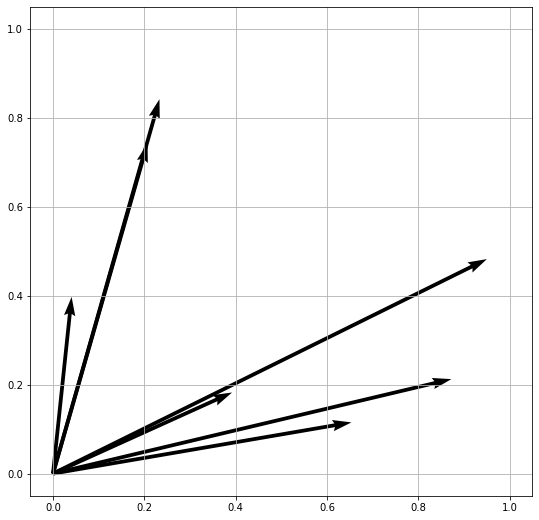

In [13]:
plt.figure(figsize=(9,9))
plt.quiver([0]*NUMBER_OF_FOODS,[0]*NUMBER_OF_FOODS,B[:,0],B[:,1],units='xy',angles='xy',scale=1,scale_units='xy')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.grid('both')
plt.show()

In [14]:
nn = cp.Variable(NUMBER_OF_FOODS)

prob = cp.Problem(cp.Maximize(nn.T@P - ALPHA*cp.sum(cp.abs(nn))),
                  [nn>= 0, nn.T@B>=1,nn.T@B<=MaxNormalizedValue,sum(nn)<=MAX_SERVINGS_PER_DAY])
prob.solve()
print(f'Servings Vector is... {nn.value}')
print(f'Sum of Servings Vector is... {sum(nn.value)}')

validFoods = [(i,x) for i,x in enumerate(nn.value) if x>0.1]
print(validFoods)
validVectors = np.array([m*B[k,:] for k,m in [x for x in validFoods]])
print(validVectors)


Servings Vector is... [1.58130338e-10 8.85277809e-01 7.71708863e-11 1.45822120e-10
 6.80882647e-01 4.21830364e-10 1.08857773e-10]
Sum of Servings Vector is... 1.5661604566425742
[(1, 0.8852778090695093), (4, 0.6808826466612533)]
[[0.84126433 0.42687335]
 [0.15873567 0.57312665]]


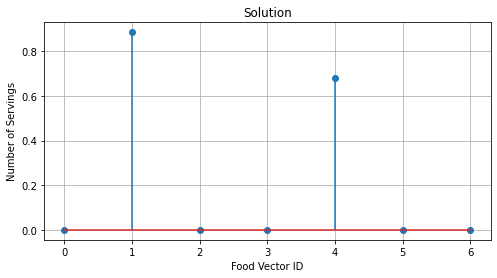

In [15]:
plt.figure(figsize=(8,4))
plt.stem(nn.value)
plt.xlabel('Food Vector ID')
plt.ylabel('Number of Servings')
plt.title('Solution')
plt.grid('both')
plt.show()

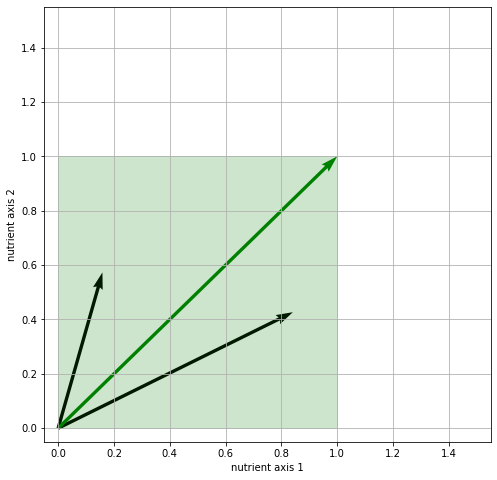

In [16]:
plt.figure(figsize=(8,8))
plt.quiver([0]*len(validFoods),
           [0]*len(validFoods),
           np.array(validVectors)[:,0],
           np.array(validVectors)[:,1],
           units='xy',
           angles='xy',
           scale=1,
           scale_units='xy')
sumVector = np.sum(validVectors,axis=0)
plt.quiver([0],
           [0],
           [sumVector[0]],
           [sumVector[1]],
           units='xy',
           angles='xy',
           scale=1,
           scale_units='xy',
           color='g')
plt.xlim([-0.05,1.55])
plt.ylim([-0.05,1.55])
plt.grid('both')
plt.fill_between([0,1],[1,1],color='g',alpha=0.2)
plt.xlabel('nutrient axis 1')
plt.ylabel('nutrient axis 2')
plt.show()
